In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import Linear, Dropout, LayerNorm
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv, global_add_pool, GraphConv
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import ReduceLROnPlateau

import networkx as nx
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import seaborn as sns
import random
import uproot

In [2]:
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
path_to_tree = "DecayTreeTuple/tuple"

def rename_columns(df):
    new_columns = {}
    for col in df.columns:
        if "_BDTTag_" in col:
            new_columns[col] = col.replace("_BDTTag_", "_SVtag_")
    df.rename(columns=new_columns, inplace=True)

# maybe don't need
def extract_float(awk_array):
    return awk_array[0] if len(awk_array) > 0 else None

In [4]:
# Read the ROOT file
tree = uproot.open("Dijet_bb_pt20_50_dw.root" + ":" + path_to_tree)
bb_df = tree.arrays(tree.keys(), library="pd", entry_start=0, entry_stop=300000) 

# Clean column names and remove unwanted columns
bb_df.columns = [col.rstrip('_') if col.endswith('_') else col for col in bb_df.columns]
rename_columns(bb_df)
columns_to_remove = [col for col in bb_df.columns if (col.startswith("H_10") or col.endswith("COV") or ("Decision" in col) or col.endswith("Tag") or col.endswith("NbTag") )]
bb_df.drop(columns=columns_to_remove, inplace=True)
for col in bb_df.columns:
    if "SVtag" in col:
        bb_df[col] = bb_df[col].apply(extract_float)
tree.close()

# Read the ROOT file
tree = uproot.open("Dijet_cc_pt20_50_dw.root" + ":" + path_to_tree)
cc_df = tree.arrays(tree.keys(), library="pd", entry_start=0, entry_stop=300000)

# Clean column names and remove unwanted columns
cc_df.columns = [col.rstrip('_') if col.endswith('_') else col for col in cc_df.columns]
rename_columns(cc_df)
columns_to_remove = [col for col in cc_df.columns if (col.startswith("H_10") or col.endswith("COV") or ("Decision" in col) or col.endswith("Tag") or col.endswith("NbTag") )]
cc_df.drop(columns=columns_to_remove, inplace=True)
for col in cc_df.columns:
    if "SVtag" in col:
        cc_df[col] = cc_df[col].apply(extract_float)
tree.close()

# Read the ROOT file
tree = uproot.open("Dijet_qq_pt20_50_dw.root" + ":" + path_to_tree)
qq_df = tree.arrays(tree.keys(), library="pd", entry_start=0, entry_stop=300000) 

# Clean column names and remove unwanted columns
qq_df.columns = [col.rstrip('_') if col.endswith('_') else col for col in qq_df.columns]
rename_columns(qq_df)
columns_to_remove = [col for col in qq_df.columns if (col.startswith("H_10") or col.endswith("COV") or ("Decision" in col) or col.endswith("Tag") or col.endswith("NbTag") )]
qq_df.drop(columns=columns_to_remove, inplace=True)
for col in qq_df.columns:
    if "SVtag" in col:
        qq_df[col] = qq_df[col].apply(extract_float)
tree.close()

/data/home/pesticci/.conda/envs/gnn_env/lib/python3.9/site-packages/uproot/interpretation/library.py:795: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[name] = series[name]
/data/home/pesticci/.conda/envs/gnn_env/lib/python3.9/site-packages/uproot/interpretation/library.py:795: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[name] = series[name]
/data/home/pesticci/.conda/envs/gnn_env/lib/python3.9/site-packages/uproot/interpretation/library.py:795: PerformanceWarning: DataFrame is highly fragmented.  This is usually the r

In [5]:
# Read the ROOT file
tree = uproot.open("Dijet_bb_pt50_dw.root" + ":" + path_to_tree)
bb50_df = tree.arrays(tree.keys(), library="pd", entry_start=0, entry_stop=300000) 

# Clean column names and remove unwanted columns
bb50_df.columns = [col.rstrip('_') if col.endswith('_') else col for col in bb50_df.columns]
rename_columns(bb50_df)
columns_to_remove = [col for col in bb50_df.columns if (col.startswith("H_10") or col.endswith("COV") or ("Decision" in col) or col.endswith("Tag") or col.endswith("NbTag") )]
bb50_df.drop(columns=columns_to_remove, inplace=True)
for col in bb50_df.columns:
    if "SVtag" in col:
        bb50_df[col] = bb50_df[col].apply(extract_float)
tree.close()

# Read the ROOT file
tree = uproot.open("Dijet_cc_pt50_dw.root" + ":" + path_to_tree)
cc50_df = tree.arrays(tree.keys(), library="pd", entry_start=0, entry_stop=300000)

# Clean column names and remove unwanted columns
cc50_df.columns = [col.rstrip('_') if col.endswith('_') else col for col in cc50_df.columns]
rename_columns(cc50_df)
columns_to_remove = [col for col in cc50_df.columns if (col.startswith("H_10") or col.endswith("COV") or ("Decision" in col) or col.endswith("Tag") or col.endswith("NbTag") )]
cc50_df.drop(columns=columns_to_remove, inplace=True)
for col in cc50_df.columns:
    if "SVtag" in col:
        cc50_df[col] = cc50_df[col].apply(extract_float)
tree.close()

# Read the ROOT file
tree = uproot.open("Dijet_qq_pt50_dw.root" + ":" + path_to_tree)
qq50_df = tree.arrays(tree.keys(), library="pd", entry_start=0, entry_stop=300000) 

# Clean column names and remove unwanted columns
qq50_df.columns = [col.rstrip('_') if col.endswith('_') else col for col in qq50_df.columns]
rename_columns(qq50_df)
columns_to_remove = [col for col in qq50_df.columns if (col.startswith("H_10") or col.endswith("COV") or ("Decision" in col) or col.endswith("Tag") or col.endswith("NbTag") )]
qq50_df.drop(columns=columns_to_remove, inplace=True)
for col in qq50_df.columns:
    if "SVtag" in col:
        qq50_df[col] = qq50_df[col].apply(extract_float)
tree.close()

/data/home/pesticci/.conda/envs/gnn_env/lib/python3.9/site-packages/uproot/interpretation/library.py:795: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[name] = series[name]
/data/home/pesticci/.conda/envs/gnn_env/lib/python3.9/site-packages/uproot/interpretation/library.py:795: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[name] = series[name]
/data/home/pesticci/.conda/envs/gnn_env/lib/python3.9/site-packages/uproot/interpretation/library.py:795: PerformanceWarning: DataFrame is highly fragmented.  This is usually the r

In [ ]:
# DataFrames and weights in a dictionary
dataframes = {
    "bb_df": (bb_df, 1),
    "cc_df": (cc_df, 1),
    "qq_df": (qq_df, 1),
    "bb50_df": (bb50_df, 0.03073569429),
    "cc50_df": (cc50_df, 0.02880875704),
    "qq50_df": (qq50_df, 0.02991944973),
}

# Apply weights to each DataFrame
for name, (df, weight) in dataframes.items():
    df['weights'] = weight

precut_b = dataframes["bb_df"][0]
precut_c = dataframes["cc_df"][0]
precut_q = dataframes["qq_df"][0]

# Concatenate DataFrames
bb_df = pd.concat([dataframes["bb_df"][0], dataframes["bb50_df"][0]])
cc_df = pd.concat([dataframes["cc_df"][0], dataframes["cc50_df"][0]])
qq_df = pd.concat([dataframes["qq_df"][0], dataframes["qq50_df"][0]])
#325m

/tmp/ipykernel_78333/1567993239.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['weights'] = weight
/tmp/ipykernel_78333/1567993239.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['weights'] = weight
/tmp/ipykernel_78333/1567993239.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  

In [ ]:
# Apply cuts and truth matching
bb_df = bb_df[(bb_df['Jet0_MC_Match'] == 1) &
                (bb_df['Jet0_MC_Jet_EfB'] > 0.6) &
                (bb_df['Jet0_PT'] > 20000) &
                (bb_df['Jet0_Eta'].between(2.2, 4.4))]
cc_df = cc_df[(cc_df['Jet0_MC_Match'] == 1) &
                (cc_df['Jet0_MC_Jet_EfD'] > 0.6) &
                (cc_df['Jet0_PT'] > 20000) &
                (cc_df['Jet0_Eta'].between(2.2, 4.4))]
qq_df = qq_df[(qq_df['Jet0_MC_Match'] == 1) &
                (qq_df['Jet0_MC_Jet_EfB'] < 0.6) &
                (qq_df['Jet0_MC_Jet_EfD'] < 0.6) &
                (qq_df['Jet0_PT'] > 20000) &
                (qq_df['Jet0_Eta'].between(2.2, 4.4))]

bb_df['Class'] = 0
bb50_df['Class'] = 0
cc_df['Class'] = 1
cc50_df['Class'] = 1
qq_df['Class'] = 2
qq50_df['Class'] = 2

combined_df = pd.concat([bb_df, bb50_df, cc_df, cc50_df, qq_df, qq50_df]).reset_index(drop=True)

# Filter columns to include only leading jet data and truth labels
combined_df = combined_df[combined_df.columns[combined_df.columns.str.contains("Jet0|Class|weights")]]
#223m

/tmp/ipykernel_78333/755528356.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  bb_df['Class'] = 0
/tmp/ipykernel_78333/755528356.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  bb50_df['Class'] = 0
/tmp/ipykernel_78333/755528356.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cc_df['Cl

In [ ]:
# Define feature columns including jet-level and daughter-level features
daughter_cols = [col for col in combined_df.columns if "_Daughters" in col]
svtag_cols = ['Jet0_SVtag_fdrMin',
 'Jet0_SVtag_ptSvrJet',
 'Jet0_SVtag_nTrk',
 'Jet0_SVtag_nTrkJet',
 'Jet0_SVtag_drSvrJet',
 'Jet0_SVtag_absQSum',
 'Jet0_SVtag_m',
 'Jet0_SVtag_mCor',
 'Jet0_SVtag_fdChi2',
 'Jet0_SVtag_ipChi2Sum',
 'Jet0_SVtag_tau',
 'Jet0_SVtag_z',
 'Jet0_SVtag_pt']
jet_cols = ['Jet0_Eta', 'Jet0_PT'] + svtag_cols
feature_cols = daughter_cols + jet_cols

# Prepare features by converting daughter information to lists and duplicating jet-level features
def prepare_features(df, jet_cols, daughter_cols):
    # Duplicate data to lists matching the number of daughters/nodes per jet/row
    for col in jet_cols:
        df[col] = df.apply(lambda row: [row[col]] * row['Jet0_nDaughters'] if isinstance(row[col], (float, int)) else row[col], axis=1)

    # Convert string values into list of floats
    for col in daughter_cols:
        df[col] = df[col].apply(lambda x: [float(num) for num in x.strip('[]').split(',')] if isinstance(x, str) else x)
    return df

df = prepare_features(combined_df, jet_cols, daughter_cols)
#47m

In [9]:
# Split data into training, validation, and test sets
b_df = df[df['Class'] == 0].sample(frac=1, random_state=42).reset_index(drop=True)
c_df = df[df['Class'] == 1].sample(frac=1, random_state=42).reset_index(drop=True)
q_df = df[df['Class'] == 2].sample(frac=1, random_state=42).reset_index(drop=True)

# Determine the minimum size among the classes for balanced training
min_size = min(len(b_df), len(c_df), len(q_df))

# Define training size (80% of the smallest class size)
train_size = int(0.8 * min_size)

# Define remaining size (20% of the smallest class size, split equally for validation and testing)
remaining_size = min_size - train_size
validation_size = remaining_size // 2
test_size = remaining_size // 2

# Create balanced training, validation, and testing sets
b_train = b_df.iloc[:train_size]
b_validation = b_df.iloc[train_size:train_size + validation_size]
b_test = b_df.iloc[train_size + validation_size:]

c_train = c_df.iloc[:train_size]
c_validation = c_df.iloc[train_size:train_size + validation_size]
c_test = c_df.iloc[train_size + validation_size:]

q_train = q_df.iloc[:train_size]
q_validation = q_df.iloc[train_size:train_size + validation_size]
q_test = q_df.iloc[train_size + validation_size:]

# Combine balanced sets
train_df = pd.concat([b_train, c_train, q_train]).sample(frac=1, random_state=42).reset_index(drop=True)
validation_df = pd.concat([b_validation, c_validation, q_validation]).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat([b_test, c_test, q_test]).sample(frac=1, random_state=42).reset_index(drop=True)

# Print sizes to confirm split
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(validation_df)}")
print(f"Testing set size: {len(test_df)}")

# Print class distributions to confirm balance
print(f"Training set class distribution:\n{train_df['Class'].value_counts()}")
print(f"Validation set class distribution:\n{validation_df['Class'].value_counts()}")
print(f"Testing set class distribution:\n{test_df['Class'].value_counts()}")

Training set size: 1023597
Validation set size: 127950
Testing set size: 342208
Training set class distribution:
Class
1    341199
2    341199
0    341199
Name: count, dtype: int64
Validation set class distribution:
Class
0    42650
2    42650
1    42650
Name: count, dtype: int64
Testing set class distribution:
Class
2    167934
0    131624
1     42650
Name: count, dtype: int64


In [10]:
print(train_df['Class'].value_counts() / len(train_df))
print(test_df['Class'].value_counts() / len(test_df))
print(validation_df['Class'].value_counts() / len(validation_df))

Class
1    0.333333
2    0.333333
0    0.333333
Name: count, dtype: float64
Class
2    0.490737
0    0.384632
1    0.124632
Name: count, dtype: float64
Class
0    0.333333
2    0.333333
1    0.333333
Name: count, dtype: float64


In [11]:
# Calculate and print the efficiency for each class (b, c, and q)
print(f"Efficiency of b-class truth matching is: {len(bb_df)/(len(precut_b)):.4f}")
print(f"Efficiency of c-class truth matching is: {len(cc_df)/(len(precut_c)):.4f}")
print(f"Efficiency of q-class truth matching is: {len(qq_df)/(len(precut_q)):.4f}")
print('')

# Print total events after truth matching and the number of events for each class
print(f"Total events after truth matching: {len(combined_df)}")
print(f"Number of b-jets after truth matching: {len(b_df)}")
print(f"Number of c-jets after truth matching: {len(c_df)}")
print(f"Number of q-jets after truth matching: {len(q_df)}")

Efficiency of b-class truth matching is: 0.7182
Efficiency of c-class truth matching is: 0.4217
Efficiency of q-class truth matching is: 0.8393

Total events after truth matching: 1493755
Number of b-jets after truth matching: 515473
Number of c-jets after truth matching: 426499
Number of q-jets after truth matching: 551783


In [ ]:
# Create graphs for training and testing
def create_graphs(df, feature_cols):

    features_list = []
    
    for _, row in df.iterrows():
        num_nodes = row['Jet0_nDaughters']
        jet_nodes = [[] for _ in range(num_nodes)]
        
        for column in feature_cols:
            cell_value = row[column]

            if isinstance(cell_value, list):
                for i in range(num_nodes):
                    jet_nodes[i].append(cell_value[i])
            else:
                for node_features in jet_nodes:
                    node_features.append(cell_value)
        
        features_list.append(jet_nodes)
    
    data_objects = []
    for idx, features in enumerate(features_list):

        x = torch.tensor(features, dtype=torch.float)

        num_nodes = x.size(0)

        # Create fully connected graph
        G = nx.complete_graph(num_nodes)
        edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
        edge_weight = torch.tensor([df['weights'].iloc[idx]], dtype=torch.float)

        y = torch.tensor([df['Class'].iloc[idx]], dtype=torch.float)
        
        data = Data(x=x, edge_index=edge_index, y=y, num_nodes=num_nodes)
        data_objects.append(data)

    return data_objects

# Create graphs for training and testing
train_data = create_graphs(train_df, feature_cols)
test_data = create_graphs(test_df, feature_cols)

# Load data in batches
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
#20m

In [21]:
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        hidden_channels = 64
        self.conv1 = SAGEConv(len(feature_cols), hidden_channels)
        self.ln1 = LayerNorm(hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.ln2 = LayerNorm(hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.ln3 = LayerNorm(hidden_channels)
        self.conv4 = SAGEConv(hidden_channels, hidden_channels)
        self.ln4 = LayerNorm(hidden_channels)
        self.lin = Linear(hidden_channels, 3)
        self.dropout = Dropout(0.3)

    def forward(self, x, edge_index, batch, edge_weight):        
        x = self.conv1(x, edge_index, edge_weight)
        x = self.ln1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index, edge_weight)
        x = self.ln2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv3(x, edge_index, edge_weight)
        x = self.ln3(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv4(x, edge_index, edge_weight)
        x = self.ln4(x)
        x = F.relu(x)

        x = global_add_pool(x, batch, edge_weight)
        x = self.lin(x)
        
        return x

model = GNN()
model = model.to(device)

In [22]:
# Define optimizer, loss function, and learning rate scheduler
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Training function
def train():
    model.train()
    total_loss = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch, data.edge_weight)
        loss = criterion(out, data.y.long()) 
        clip_grad_norm_(model.parameters(), max_norm=0.5)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    avg_loss = total_loss / len(train_loader.dataset)

    return avg_loss

# Testing function
def test(loader):
    model.eval()
    total_correct = 0
    total_samples = 0
    total_loss = 0
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch, data.edge_weight)
            loss = criterion(out, data.y.long())
            pred = torch.argmax(out, dim=1)  # Get class with the highest probability
            correct = (pred == data.y).sum().item()
            total_correct += correct
            total_samples += len(data.y)
            total_loss += loss.item() * data.num_graphs

        avg_loss = total_loss / len(loader.dataset)
        acc = total_correct / total_samples
    return avg_loss, acc

# Training parameters
num_epochs = 200

# Initialize lists for storing loss and accuracy values
train_loss_values = []
train_acc_values = []
test_loss_values = []
test_acc_values = []

# Training loop
for epoch in range(num_epochs):

    train_loss = train()
    train_loss_values.append(train_loss)

    train_acc = test(train_loader)[1]
    train_acc_values.append(train_acc)

    test_loss, test_acc = test(test_loader)
    test_loss_values.append(test_loss)
    test_acc_values.append(test_acc)

    scheduler.step(test_loss)

    print(f'Epoch: {epoch+1:03d}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

    # Save the model and results every 50 epochs
    if (epoch + 1) % 50 == 0:
        torch.save(model.state_dict(), 'combined_model1.pth')
        print('Model saved as combined_model1.pth.')

        results_df = pd.DataFrame({
            'Epoch': list(range(1, epoch + 2)),
            'Train Loss': train_loss_values,
            'Test Loss': test_loss_values,
            'Train Accuracy': train_acc_values,
            'Test Accuracy': test_acc_values
        })
        results_df.to_csv('combined_training1.csv', index=False)
        print('Training results saved as combined_training1.csv.')

torch.save(model.state_dict(), 'combined_model1.pth')
print('Model saved as combined_model1.pth. Training complete.')

results_df = pd.DataFrame({
    'Epoch': list(range(1, num_epochs+1)),
    'Train Loss': train_loss_values,
    'Test Loss': test_loss_values,
    'Train Accuracy': train_acc_values,
    'Test Accuracy': test_acc_values
})

results_df.to_csv('combined_training1.csv', index=False)
print('Training results saved as combined_training1.csv. Training complete.')
#82 min for 20 epochs

Epoch: 001, Train Loss: 0.9956, Test Loss: 0.9110, Train Acc: 0.5056, Test Acc: 0.5982
Epoch: 002, Train Loss: 0.9550, Test Loss: 0.9434, Train Acc: 0.5191, Test Acc: 0.5118
Epoch: 003, Train Loss: 0.9458, Test Loss: 0.9518, Train Acc: 0.5214, Test Acc: 0.4780
Epoch: 004, Train Loss: 0.9403, Test Loss: 0.9100, Train Acc: 0.5273, Test Acc: 0.5383
Epoch: 005, Train Loss: 0.9370, Test Loss: 0.8956, Train Acc: 0.5203, Test Acc: 0.5805
Epoch: 006, Train Loss: 0.9342, Test Loss: 0.9100, Train Acc: 0.5297, Test Acc: 0.5448
Epoch: 007, Train Loss: 0.9318, Test Loss: 0.9346, Train Acc: 0.5300, Test Acc: 0.5000
Epoch: 008, Train Loss: 0.9300, Test Loss: 0.9076, Train Acc: 0.5348, Test Acc: 0.5308
Epoch: 009, Train Loss: 0.9282, Test Loss: 0.8849, Train Acc: 0.5287, Test Acc: 0.5743
Epoch: 010, Train Loss: 0.9264, Test Loss: 0.9097, Train Acc: 0.5355, Test Acc: 0.5371
Epoch: 011, Train Loss: 0.9248, Test Loss: 0.9134, Train Acc: 0.5348, Test Acc: 0.5181
Epoch: 012, Train Loss: 0.9231, Test Loss: 

In [23]:
# Reload training data to produce plots
training = pd.read_csv('combined_training1.csv')
train_loss_values = training['Train Loss'].to_list()
test_loss_values = training['Test Loss'].to_list()
train_acc_values = training['Train Accuracy'].to_list()
test_acc_values = training['Test Accuracy'].to_list()

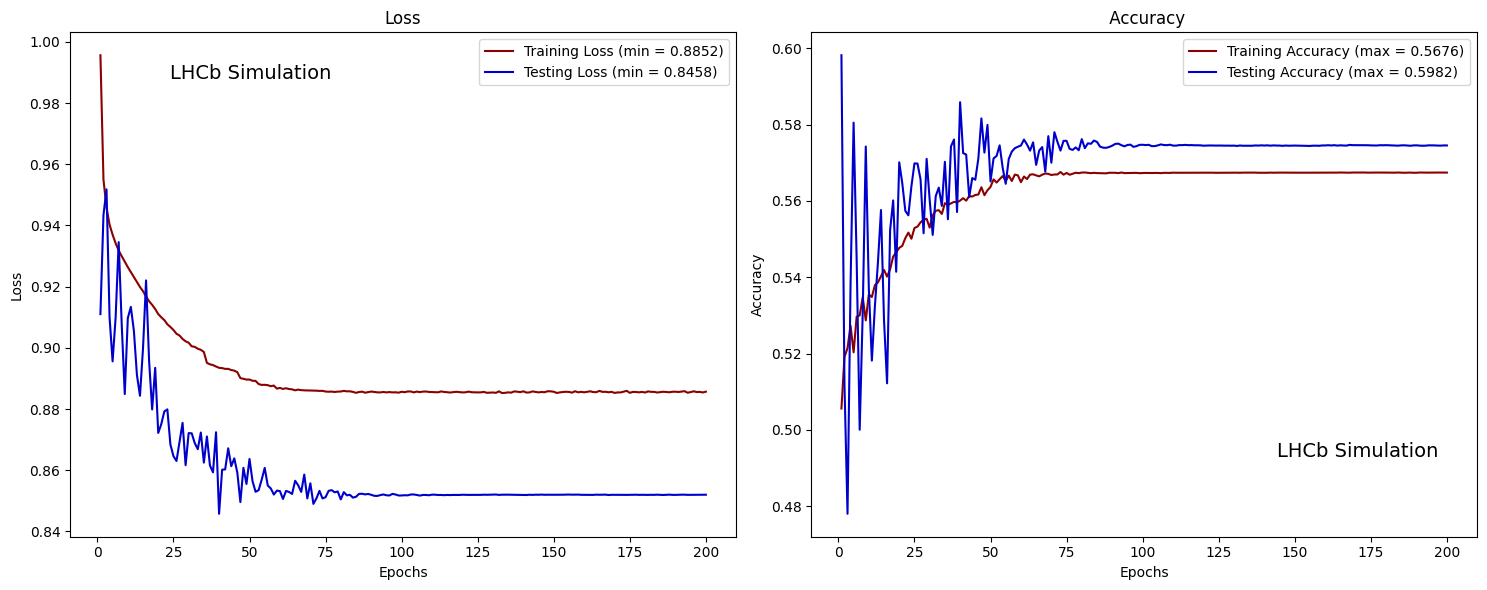

In [24]:
# Plot Loss and Accuracy
def plot_training_results():
    epochs = range(1, len(train_loss_values) + 1)

    mean_train_loss = np.mean(train_loss_values)
    mean_test_loss = np.mean(test_loss_values)
    mean_train_acc = np.mean(train_acc_values)
    mean_test_acc = np.mean(test_acc_values)

    min_train_loss = min(train_loss_values)
    min_test_loss = min(test_loss_values)
    max_train_acc = max(train_acc_values)
    max_test_acc = max(test_acc_values)

    final_train_loss = train_loss_values[-1]
    final_test_loss = test_loss_values[-1]
    final_train_acc = train_acc_values[-1]
    final_test_acc = test_acc_values[-1]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    #fig.suptitle('Training Results', fontsize=16)

    # Plot Loss
    ax1.plot(epochs, train_loss_values, color='darkred', label=(f"Training Loss (min = {min_train_loss:.4f})"))
    ax1.plot(epochs, test_loss_values, color='mediumblue', label=(f"Testing Loss (min = {min_test_loss:.4f})"))

    ax1.text(0.15, 0.90, "LHCb Simulation", transform=ax1.transAxes, fontsize=14, verticalalignment='bottom')

    ax1.set_title('Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='best')

    # Plot  Accuracy
    ax2.plot(epochs, train_acc_values, color='darkred', label=(f"Training Accuracy (max = {max_train_acc:.4f})"))
    ax2.plot(epochs, test_acc_values, color='mediumblue', label=(f"Testing Accuracy (max = {max_test_acc:.4})"))

    ax2.text(0.7, 0.15, "LHCb Simulation", transform=ax2.transAxes, fontsize=14, verticalalignment='bottom')

    ax2.set_title(' Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='best')

    plt.style.use('default')
    plt.tight_layout()
    plt.show()
    
# After your training loop, call the function:
plot_training_results()

In [ ]:
# True class labels and predicted probabilities
y_true = []  
y_scores = []  

# Load model and switch to evaluation mode
model.load_state_dict(torch.load('combined_model1.pth'))
model = model.to('cpu')
model.eval()

with torch.no_grad():
    for data in test_loader:
        # Forward pass
        out = model(data.x, data.edge_index, data.batch, data.edge_weight)
        prob = torch.softmax(out, dim=1) 
        
        # Append true class labels and predicted probabilities
        y_true.append(data.y.numpy())
        y_scores.append(prob.numpy())  # Predicted probabilities for each class

# Concatenate the true labels and predicted probabilities
y_true = np.concatenate(y_true)
y_scores = np.concatenate(y_scores)

# Calculate ROC and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}  # Renamed to avoid conflict with the function 'auc'

num_classes = y_scores.shape[1]  # Number of classes (columns in y_scores)

for i in range(num_classes):
    fpr[i], tpr[i], thresholds = roc_curve(y_true == i, y_scores[:, i]) 
    roc_auc[i] = roc_auc_score(y_true == i, y_scores[:, i])

# Save the ROC and AUC results for each class
np.save('combined_fpr.npy', fpr)
np.save('combined_tpr.npy', tpr)
np.save('combined_roc_auc.npy', roc_auc)

# Create the combined true labels for B and C (class 1 and class 2)
combined_true = np.where((y_true == 1) | (y_true == 2), 1, 0)

# Combine predicted probabilities for B and C (class 1 and class 2)
combined_scores = np.maximum(y_scores[:, 1], y_scores[:, 2])

# Compute ROC and AUC for B + C vs Q
fpr_combined, tpr_combined, _ = roc_curve(combined_true, combined_scores)

# Calculate AUC for the combined case
roc_auc_combined = roc_auc_score(combined_true, combined_scores)

# Optionally, save the combined ROC and AUC result
np.save('combined_fpr_b_c_vs_q.npy', fpr_combined)
np.save('combined_tpr_b_c_vs_q.npy', tpr_combined)
np.save('combined_roc_auc_b_c_vs_q.npy', roc_auc_combined)

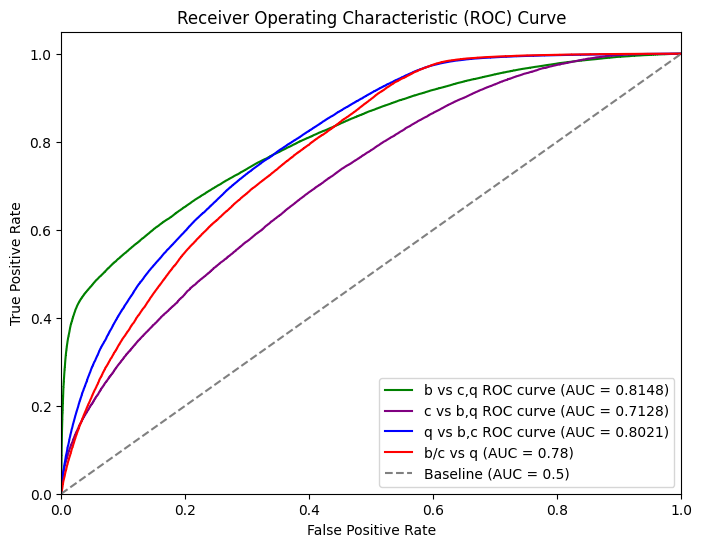

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], color='green', label=f'b vs c,q ROC curve (AUC = {auc[0]:.4f})')
plt.plot(fpr[1], tpr[1], color='purple', label=f'c vs b,q ROC curve (AUC = {auc[1]:.4f})')
plt.plot(fpr[2], tpr[2], color='blue', label=f'q vs b,c ROC curve (AUC = {auc[2]:.4f})')
plt.plot(fpr_combined, tpr_combined, color='red', label=f'b,c vs q (AUC = {auc_combined:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Baseline (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [27]:
def make_predictions():
    # Select a random integer for sampling
    random_integer = np.random.randint(0, len(df))
    sample_jet = df.iloc[random_integer:random_integer+1].copy()

    # Filter columns related to Jet0
    sample_jet = sample_jet.filter(like='Jet0')

    # Define feature columns
    daughter_cols = [col for col in sample_jet.columns if "_Daughters" in col]
    svtag_cols = ['Jet0_SVtag_fdrMin', 'Jet0_SVtag_ptSvrJet', 'Jet0_SVtag_nTrk', 
                  'Jet0_SVtag_nTrkJet', 'Jet0_SVtag_drSvrJet', 'Jet0_SVtag_absQSum', 
                  'Jet0_SVtag_m', 'Jet0_SVtag_mCor', 'Jet0_SVtag_fdChi2', 'Jet0_SVtag_ipChi2Sum', 
                  'Jet0_SVtag_tau', 'Jet0_SVtag_z', 'Jet0_SVtag_pt']
    jet_cols = ['Jet0_Eta', 'Jet0_PT'] + svtag_cols
    feature_cols = daughter_cols + jet_cols

    # Process feature columns
    for col in feature_cols:
        if col in sample_jet.columns:
            sample_jet[col] = sample_jet.apply(lambda row: [row[col]] * int(row['Jet0_nDaughters']) if isinstance(row[col], (float, int)) else row[col], axis=1)
            sample_jet[col] = sample_jet[col].apply(lambda x: [float(num) for num in x.strip('[]').split(',')] if isinstance(x, str) else x)

    # Obtain features of each node within the graph
    features_list = []
    for _, row in sample_jet.iterrows():
        num_nodes = int(row['Jet0_nDaughters'])
        jet_nodes = [[] for _ in range(num_nodes)]
        
        for column in feature_cols:
            cell_value = row[column]

            if isinstance(cell_value, list):
                for i in range(num_nodes):
                    jet_nodes[i].append(cell_value[i])
            else:
                for node_features in jet_nodes:
                    node_features.append(cell_value)
        
        features_list.append(jet_nodes)
    
    # Create graph representation with data objects
    data_objects = []
    for features in features_list:
        x = torch.tensor(features, dtype=torch.float)

        num_nodes = x.size(0)

        # Create a fully connected graph
        G = nx.complete_graph(num_nodes)
        edge_index = torch.tensor(list(G.edges)).t().contiguous()

        data = Data(x=x, edge_index=edge_index)
        data_objects.append(data)

    # Make predictions
    for data in data_objects:
        with torch.no_grad():
            out = model(data.x, data.edge_index, data.batch, data.edge_weight)
            probabilities = F.softmax(out, dim=1) 
            predicted_classes = torch.argmax(probabilities, dim=1) # Get class with the highest probability for each node

            # Output the probabilities and predicted classes
            print(f'Probabilities: {probabilities.squeeze().tolist()}')
            print(f'Predicted Classes: {predicted_classes.tolist()}')

    return probabilities.squeeze().tolist()

# Loop to make 100 predictions
for i in range(100):
    make_predictions()

Probabilities: [0.19199879467487335, 0.19846487045288086, 0.609536349773407]
Predicted Classes: [2]
Probabilities: [0.029998380690813065, 0.15462012588977814, 0.8153814673423767]
Predicted Classes: [2]
Probabilities: [0.29106950759887695, 0.35899513959884644, 0.34993526339530945]
Predicted Classes: [1]
Probabilities: [0.371735155582428, 0.34680745005607605, 0.28145742416381836]
Predicted Classes: [0]
Probabilities: [0.21333065629005432, 0.28680548071861267, 0.49986377358436584]
Predicted Classes: [2]
Probabilities: [0.18241488933563232, 0.5747252106666565, 0.24285989999771118]
Predicted Classes: [1]
Probabilities: [0.22035770118236542, 0.26341572403907776, 0.5162265300750732]
Predicted Classes: [2]
Probabilities: [0.33590900897979736, 0.428739458322525, 0.2353515475988388]
Predicted Classes: [1]
Probabilities: [0.4985079765319824, 0.3360711932182312, 0.16542088985443115]
Predicted Classes: [0]
Probabilities: [0.12022829055786133, 0.5753860473632812, 0.30438563227653503]
Predicted Class

In [ ]:
# Separate b and q data from testing dataset (preprocessed)
b = combined_df[combined_df.Class == 0]
c = combined_df[combined_df.Class == 1]
q = combined_df[combined_df.Class == 2]

b_data = create_graphs(b, feature_cols)
c_data = create_graphs(c, feature_cols)
q_data = create_graphs(q, feature_cols)

b_prob = []
c_prob = []
q_prob = []

In [ ]:
def get_probabilities(data_list, target_class):

    prob_list = []
    model.eval()
    with torch.no_grad():
        for data in data_list:
            # Model forward pass
            out = model(data.x, data.edge_index, None, data.edge_weight)  # Shape: [batch_size, num_classes]
            probabilities = F.softmax(out, dim=1)  # Shape: [batch_size, num_classes]
        
            # Append probabilities for the target class
            target_probs = probabilities[:, target_class].cpu().numpy()  # Extract probabilities for target class
            prob_list.extend(target_probs)
    
    return np.array(prob_list)

# Compute probabilities for b, c, and q data
b_prob = get_probabilities(b_data, target_class=0)
c_prob = get_probabilities(c_data, target_class=1)
q_prob = get_probabilities(q_data, target_class=2)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/data/home/pesticci/.conda/envs/gnn_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_78333/1402395677.py", line 18, in <module>
    b_prob = get_probabilities(b_data, target_class=0)
  File "/tmp/ipykernel_78333/1402395677.py", line 8, in get_probabilities
    out = model(data.x, data.edge_index, None, data.edge_weight)  # Shape: [batch_size, num_classes]
  File "/data/home/pesticci/.conda/envs/gnn_env/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/tmp/ipykernel_78333/612123851.py", line 17, in forward
    x = self.conv1(x, edge_index, edge_weight)
  File "/data/home/pesticci/.conda/envs/gnn_env/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/data/home/pesticci/

: 

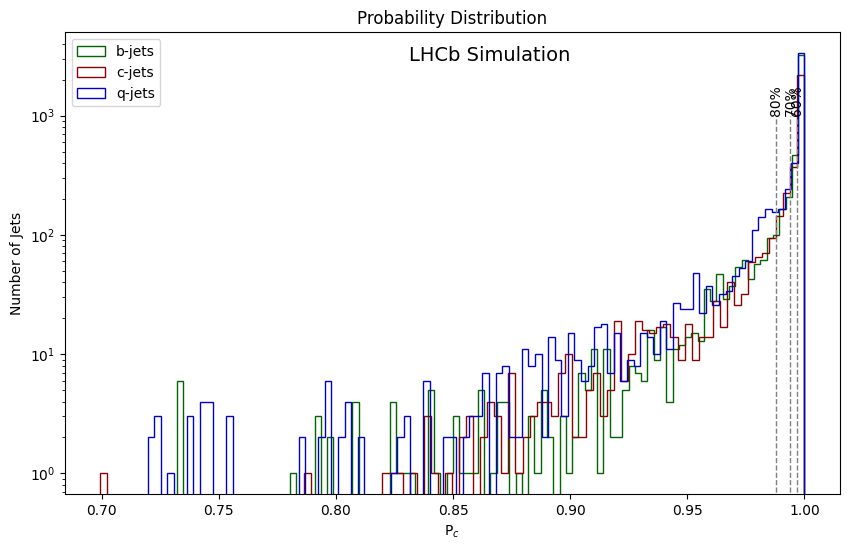

In [ ]:
def plot_probability_distribution(c_prob, q_prob, target_efficiencies):

    # Sort c-jet probabilities in descending order for cutoff calculations
    sorted_c_prob = np.sort(c_prob)[::-1]
    
    # Calculate cutoffs for each efficiency level
    cutoffs = {}
    for efficiency in target_efficiencies:
        cutoff_index = int(len(sorted_c_prob) * efficiency)
        cutoffs[efficiency] = sorted_c_prob[cutoff_index - 1] if cutoff_index > 0 else sorted_c_prob[0]
    
    # Plot histograms for c-jet and q-jet probabilities
    plt.figure(figsize=(10, 6))
    b_values, b_bins, _ = plt.hist(b_prob, bins=100, label='b-jets', color='darkgreen', histtype='step')
    c_values, c_bins, _ = plt.hist(c_prob, bins=100, label='c-jets', color='darkred', histtype='step')
    q_values, q_bins, _ = plt.hist(q_prob, bins=100, label='q-jets', color='mediumblue', histtype='step')

    max_y = max(max(c_values), max(q_values))
    
    # Mark cutoffs for selected efficiencies
    for i, (efficiency, cutoff) in enumerate(cutoffs.items()):
        plt.vlines(x=cutoff, ymin=0, ymax=max_y * 0.3, color='grey', linestyle='--', linewidth=1)
        plt.text(cutoff, max_y*0.3, f'{int(efficiency * 100)}%', ha='center', va='bottom', rotation=90)

    plt.xlabel("P$_c$")
    plt.ylabel("Number of Jets")
    plt.text(0.9, max_y * 0.8, "LHCb Simulation", fontsize=14, verticalalignment='bottom', horizontalalignment='right')
    plt.title("Probability Distribution")
    plt.yscale('log')
    plt.legend(loc='best')
    plt.show()

target_efficiencies = [0.6, 0.7, 0.8]
plot_probability_distribution(c_prob, q_prob, target_efficiencies)